In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import sklearn # machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import xgboost as xgb
print("xgb version: {}". format(xgb.__version__))
from xgboost import plot_importance
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV 

import imblearn # for using oversampling
print("imblearn version: {}". format(imblearn.__version__))
from imblearn.over_sampling import SMOTE

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

matplotlib version: 3.4.1
scikit-learn version: 0.24.1
xgb version: 1.4.0
imblearn version: 0.8.0
/kaggle/input/tabular-playground-series-may-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2021/train.csv
/kaggle/input/tabular-playground-series-may-2021/test.csv


# About

This is my notebook for the Tabular Playground Series - May 2021 using XGBoost. I have a [seperate notebook for my EDA](https://www.kaggle.com/melanie7744/tps5-eda-raising-more-questions-than-answers).

I frist ran plain XGBoost with default parameters to see how it fares. Then I 
- removed the duplicates from the training set
- one hot encoded four parameters that I guessed to be categorical
- ran Grid Search CV to search for better hyperparameters
- increased the number of estimators and early stopping rounds
- implemented oversampling (SMOTE) to deal with the imbalance in the target variable (corrected later on, initial implementation was incorrect)
- reduced the learning rate

The results are listed as comments below. It was an iterative process with the current version of the notebook only showing the last step.


I ran out of things to try with XGBoost. My biggest issue is, that I did not find a way to deal with the imbalance of the target variable. Stratification during generation of the validation set was not enough, neither was oversampling. As a last tuning step reducing the learning rate helped to get a better log loss score. But only slightly. 

Any suggesetions are very welcome!

In [2]:
df_train = pd.read_csv('../input/tabular-playground-series-may-2021/train.csv')
df_test = pd.read_csv('../input/tabular-playground-series-may-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-may-2021/sample_submission.csv') 

# label encode the target column
le = LabelEncoder()
df_train.target = le.fit_transform(df_train.target)
features = df_train.columns[1:51]
#features = [col for col in df_train.columns if col.startswith("feature")]
df_train[features].head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,0,1,0,1,0,0,0,0,0,...,3,0,0,21,0,0,0,0,0,0
1,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,2,...,0,0,1,0,0,0,0,13,2,0
3,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [3]:
# drop duplicates
display(df_train[df_train[features].duplicated(keep="first")])
df_train= df_train.drop_duplicates(subset = features)
display(df_train.shape)

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
44423,44423,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
73244,73244,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
80571,80571,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
89009,89009,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


(99996, 52)

In [4]:
# let's try to one hot encode all columns that might be "true categoric features". This is just a guess based on my EDA (seperate notebook)
cat_features = ["feature_2", "feature_13", "feature_22", "feature_36"]
#df_train = pd.get_dummies(df_train, columns= cat_features)
#df_test = pd.get_dummies(df_test, columns= cat_features)

In [5]:
# prepare test data
df_test.head()
X_test=df_test.drop(columns="id")
X_test.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,0,0,0,0,0,4,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,2,0,7,7,...,3,0,1,0,0,0,1,0,2,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,6,0
3,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,6,9,14,3
4,0,0,0,0,0,0,1,0,4,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
# define X and y
X = df_train.drop(columns=["id","target"])
y = df_train.target
display(X.shape)
df_train.target.value_counts()

(99996, 50)

1    57496
2    21420
3    12591
0     8489
Name: target, dtype: int64

In [7]:
# dividing X, y into train and test data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0, stratify=y)
display(X_train.shape)
y_train.value_counts()

(74997, 50)

1    43122
2    16065
3     9443
0     6367
Name: target, dtype: int64

In [8]:
# in this cell SMOTE is implemented, can be turned on or off, balanced oversampling is tested and oversampling with a sampling strategy
# I turned if OFF as the results were worse

# scale the data when using SMOTE as it runs a KNN algorithm internally
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)
#X_test = scaler.transform(X_test)

#oversample = SMOTE() # for balanced oversampling
#strategy = {0:10000, 1:43122, 2:16065, 3:14000} # setting sampling goals manually: only slight increase in underrepresented classes
#oversample = SMOTE(sampling_strategy=strategy) # for strategic oversampling
#X_train, y_train = oversample.fit_resample(X_train, y_train) # oversampling must only be used on training data

#display(X_train.shape)
#y_train.value_counts()

In [9]:
# train model
clf_xgb = xgb.XGBClassifier(objective='multi:softprob', 
                            seed=42, 
                            use_label_encoder=False, 
                            num_class=4, 
                            colsample_bytree=0.5, 
                            subsample=0.9,
                            eta=0.1,
                            gamma = 0.25,
                            max_depth = 3,
                            reg_lambda = 10,
                            n_estimators = 500
                            )
clf_xgb.fit(X_train, 
            y_train,
            verbose=True,
            ## the next three arguments set up early stopping.
            early_stopping_rounds=50,
            eval_metric=['mlogloss'],
            eval_set=[(X_train, y_train),(X_val, y_val)]
           )
# from Grid Search Round 2: {'gamma': 0.25, 'learning_rate': 0.3, 'max_depth': 3, 'reg_lambda': 10}

[0]	validation_0-mlogloss:1.34714	validation_1-mlogloss:1.34714
[1]	validation_0-mlogloss:1.31407	validation_1-mlogloss:1.31411
[2]	validation_0-mlogloss:1.28595	validation_1-mlogloss:1.28616
[3]	validation_0-mlogloss:1.26204	validation_1-mlogloss:1.26233
[4]	validation_0-mlogloss:1.24149	validation_1-mlogloss:1.24189
[5]	validation_0-mlogloss:1.22373	validation_1-mlogloss:1.22430
[6]	validation_0-mlogloss:1.20851	validation_1-mlogloss:1.20919
[7]	validation_0-mlogloss:1.19536	validation_1-mlogloss:1.19612
[8]	validation_0-mlogloss:1.18391	validation_1-mlogloss:1.18478
[9]	validation_0-mlogloss:1.17393	validation_1-mlogloss:1.17485
[10]	validation_0-mlogloss:1.16526	validation_1-mlogloss:1.16625
[11]	validation_0-mlogloss:1.15775	validation_1-mlogloss:1.15874
[12]	validation_0-mlogloss:1.15119	validation_1-mlogloss:1.15223
[13]	validation_0-mlogloss:1.14545	validation_1-mlogloss:1.14659
[14]	validation_0-mlogloss:1.14048	validation_1-mlogloss:1.14169
[15]	validation_0-mlogloss:1.13613	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.1, gamma=0.25,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_class=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=10, scale_pos_weight=None, seed=42, subsample=0.9,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [10]:
# 1.[58]	validation_0-mlogloss:1.01002	validation_1-mlogloss:1.09621 - with eta= 0.3
# 2.[81]	validation_0-mlogloss:1.01296	validation_1-mlogloss:1.09486 - with eta= 0.2
# 3.[82]	validation_0-mlogloss:1.01188	validation_1-mlogloss:1.09464 - with the 4 duplicates in training data removed
# 4.[76]	validation_0-mlogloss:1.01515	validation_1-mlogloss:1.09554 - with one hot encoding of 4 columns
# 5.[138]	validation_0-mlogloss:1.06422	validation_1-mlogloss:1.09208 - with optimized parameters and increased n_estimators as early stopping was not triggered with 100 estimators
# 6.[159]	validation_0-mlogloss:1.06088	validation_1-mlogloss:1.09217 - one hot encoding removed
# 7.[170]	validation_0-mlogloss:1.05924	validation_1-mlogloss:1.09238 - changed n_estimators from 200 to 500 and early_stopping from 20 to 50
# 8.[499]	validation_0-mlogloss:1.18783	validation_1-mlogloss:1.22255 - with balanced SMOTE, early stopping did not kick in 
# 9.[173]	validation_0-mlogloss:1.08663	validation_1-mlogloss:1.12238 - with strategic SMOTE
# 10.[280]	validation_0-mlogloss:1.05667	validation_1-mlogloss:1.09219 - no SMOTE, eta = 0.2
# 11.[241]	validation_0-mlogloss:1.02529	validation_1-mlogloss:1.09228 - with strategic SMOTE used correctly (scaling and only X_train)
#12.[280]	validation_0-mlogloss:1.05667	validation_1-mlogloss:1.09218 - no SMOTE, just scaling (as expected same as #10.)
#13.[348]	validation_0-mlogloss:1.00963	validation_1-mlogloss:1.09786 - balanced SMOTE used correctly (scaling and only X_train)
#14.[326]	validation_0-mlogloss:1.06012	validation_1-mlogloss:1.09166 - not SMOTE, eta =1.5
#15.[499]	validation_0-mlogloss:1.05940	validation_1-mlogloss:1.09133 - eta =1, used the maximum numbers of estimators

In [11]:
# 1.Public Score: not submitted
# 2.Public Score: 1.09190
# 3.Public Score: 1.09128
# 4.Public Score: 1.09082
# 5.Public Score: 1.08813
# 6.Public Score: 1.08804
# 7.Public Score: 1.08804
# 8.Public Score: 1.27648
# 9.Public Score: 1.09327
#10.Public Score: 1.08792
#11.Public Score: 1.08950
#12.Public Score: 1.08894
#13.Public Score: 1.09411
#14.Public Score: 1.08779

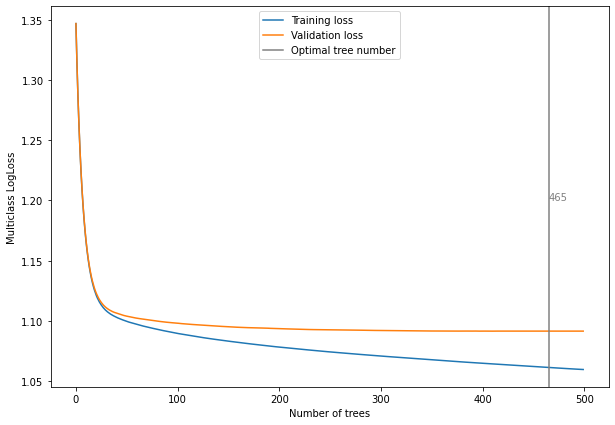

In [12]:
# visualize training/validation results
results = clf_xgb.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["mlogloss"], label="Training loss")
plt.plot(results["validation_1"]["mlogloss"], label="Validation loss")
plt.axvline(clf_xgb.best_ntree_limit, color="gray", label="Optimal tree number")
plt.annotate(str(clf_xgb.best_ntree_limit), xy=(clf_xgb.best_ntree_limit, 1.2),color="gray")
plt.xlabel("Number of trees")
plt.ylabel("Multiclass LogLoss")
plt.legend()
plt.show()

This plot shows the number of estimators used for the "optimal" result. No need to increase the number of estimators beyond that. 
Depending on whether SMOTE is used or not the picture changes.

In [13]:
predicted_classes = clf_xgb.predict(X_val) # used only for confusion matrix later, therefore with X_val
predictions = clf_xgb.predict_proba(X_test) # used for submission
predictions

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


array([[0.0871255 , 0.60707337, 0.18503211, 0.12076896],
       [0.07097459, 0.69715583, 0.14647041, 0.08539917],
       [0.08693919, 0.6246195 , 0.17511602, 0.11332532],
       ...,
       [0.08976915, 0.48951364, 0.24117762, 0.1795396 ],
       [0.08242496, 0.57578915, 0.16810647, 0.17367944],
       [0.09009136, 0.5715667 , 0.19851887, 0.13982308]], dtype=float32)

Accuracy: 0.5806632265290612

Confusion Matrix:


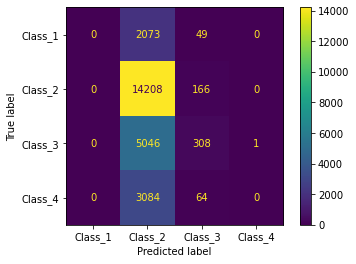

In [14]:
class_labels = ["Class_1","Class_2","Class_3","Class_4"]
plot_confusion_matrix(clf_xgb, X_val, y_val, display_labels=class_labels)
print("Accuracy: {}\n".format(accuracy_score(y_val,predicted_classes)))
print("Confusion Matrix:")

In [15]:
pd.Series(predicted_classes).value_counts(normalize=True)
# Class_2 is predicted 98% of the time :(
# when the 4 duplicates in the training set are dropped, Class_1 is not predicted at all :(
# with one hot encoding of 4 columns Class_3 is not predicted at all
# interesting optimization: now it only predicts 2 classes, but logloss is better
# with one hot encoding removed again only Class_1 is not predicted. Accuracy is slightly better
# with balanced SMOTE all classes are predicted, but much more evenly than they should be. !! SMOTE was used wrongly !!
# with strategic SMOTE the confusion matrix looks more similar to no SMOTE. As expected. Now it's Class_1 that is not predicted at all.!! SMOTE was used wrongly !!
# strategic SMOTE used correctly only Class_2 and Class_3 are predicted
# balanced SMOTE used correctly: Class_1 is not predicted

1    0.976479
2    0.023481
3    0.000040
dtype: float64

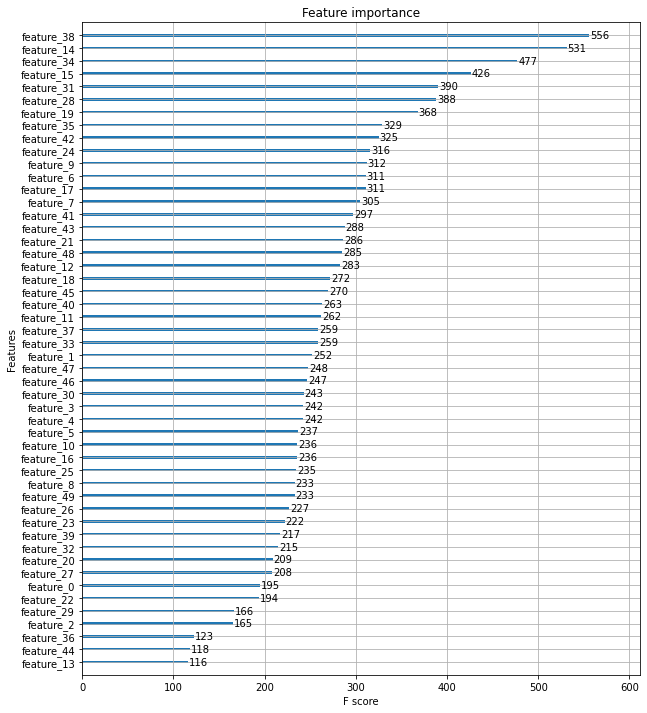

In [16]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(clf_xgb,(10,12) )
plt.show()

Looking at the feature importance graph, it looks like one hot encoding is quite unimportant. However it led to a small improvement in the Public Score. I will run one last try and remove one hot encoding again. Result: those features are still at the end of the importance list, so one-hot encoding was not the culprit. 

In [17]:
# create submission file
sample_submission.drop(columns=class_labels, inplace=True)
submission = (sample_submission.join(pd.DataFrame(data=predictions, columns=class_labels)))
submission.to_csv("my_submission.csv", index=False)
submission

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.087126,0.607073,0.185032,0.120769
1,100001,0.070975,0.697156,0.146470,0.085399
2,100002,0.086939,0.624619,0.175116,0.113325
3,100003,0.078724,0.570829,0.258533,0.091914
4,100004,0.081991,0.622229,0.191152,0.104627
...,...,...,...,...,...
49995,149995,0.083464,0.707328,0.151522,0.057686
49996,149996,0.075140,0.655056,0.131391,0.138413
49997,149997,0.089769,0.489514,0.241178,0.179540
49998,149998,0.082425,0.575789,0.168106,0.173679


In [18]:
# Grid Search for better hyperparameters
# Round 1
#param_grid = {
#     'max_depth': [3, 4, 5], #4
#     'learning_rate': [0.2, 0.1, 0.05],
#     'gamma': [0, 0.25, 0.5],
#     'reg_lambda': [5.0, 10.0, 15.0] #10
# }
# Round 2
param_grid = {
     'max_depth': [2 ,3, 4],
     'learning_rate': [0.3, 0.2, 0.1],
     'gamma': [0.25],
     'reg_lambda' : [10] #10
 }
optimal_params = GridSearchCV(
     estimator=xgb.XGBClassifier(objective='multi:softprob', eval_metric=['mlogloss'], seed=42, use_label_encoder=False, colsample_bytree=0.5, subsample=0.9),
     param_grid=param_grid,
     scoring = 'neg_log_loss',
     verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
     cv = 3
 )
# Round 1: {'gamma': 0.25, 'learning_rate': 0.2, 'max_depth': 3, 'reg_lambda': 10.0}
# Round 2: {'gamma': 0.25, 'learning_rate': 0.3, 'max_depth': 3, 'reg_lambda': 10}

In [19]:
#optimal_params.fit(X_train,y_train,early_stopping_rounds=30,eval_set=[(X_val, y_val)],verbose=50)
#print(optimal_params.best_params_)